# Feature Interaction Analysis

In [1]:
# Importing all necessary liabries for the task.
import pandas as pd 
import numpy as np    
import seaborn as sns  
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import re
 

In [2]:
# Read into the json files and view the first 5 rows of the train dataset
train = pd.read_json('data/train.json')
test = pd.read_json('data/test.json')

train.head()

Id   Income  Age  Experience Married/Single House_Ownership  \
0  172392  4588175   49          20         single          rented   
1  246131  6510821   31          15         single          rented   
2   51741  9338129   26           7         single          rented   
3  143394  8053436   42           8         single          rented   
4  146824  3589662   42          18         single          rented   

  Car_Ownership        Profession             CITY          STATE  \
0            no         Secretary         Bilaspur   Chhattisgarh   
1            no         Librarian         Amritsar         Punjab   
2            no            Artist      Farrukhabad  Uttar_Pradesh   
3            no              Chef  Mysore[7][8][9]      Karnataka   
4           yes  Technical_writer         Bareilly  Uttar_Pradesh   

   CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
0                6                 11          0  
1               12                 10          1  
2                4                 14          0  
3                8                 11          1  
4               13                 13          0

In [3]:
train.shape , test.shape #checking the dimensionality of the train and test 

((201600, 13), (50400, 12))

In [4]:
# A function to compare the statistic summaries of both train and test set

def compare_train_test_summary(train, test, target_col=None, cat_threshold=0.15, num_threshold=0.15):
    """
    
    Compare and visualize numeric and categorical feature summaries between train and test datasets, check for missing values and visualizes flagged features.

    Args:
        train (pd.DataFrame): Training set
        test (pd.DataFrame): Testing set
        target_col (str): Target column to exclude (optional)
        cat_threshold (float): Threshold for top category proportion difference
        num_threshold (float): Threshold for numeric mean/std difference
    """
    print("\n Comparing Train vs Test Summary Statistics...\n")

    if target_col:
        common_cols = train.columns.intersection(test.columns).drop(target_col, errors='ignore')
    else:
        common_cols = train.columns.intersection(test.columns)

    numeric_cols = train[common_cols].select_dtypes(include=['number']).columns
    categorical_cols = train[common_cols].select_dtypes(include=['object', 'category']).columns

    flagged_numeric = []
    flagged_categorical = []

    print(" Numeric Features Summary Comparison")
    print("-" * 50)
    for col in numeric_cols:
        train_stats = train[col].describe()
        test_stats = test[col].describe()

        mean_diff = abs(train_stats['mean'] - test_stats['mean']) / max(train_stats['mean'], 1e-6)
        std_diff = abs(train_stats['std'] - test_stats['std']) / max(train_stats['std'], 1e-6)

        print(f"\n Feature: {col}")
        print(f"Train -> mean: {train_stats['mean']:.2f}, std: {train_stats['std']:.2f}, nulls: {train[col].isnull().sum()}")
        print(f"Test  -> mean: {test_stats['mean']:.2f}, std: {test_stats['std']:.2f}, nulls: {test[col].isnull().sum()}")

        if mean_diff > num_threshold:
            print(" Mean difference > threshold")
            flagged_numeric.append(col)
        if std_diff > num_threshold:
            print(" Std deviation difference > threshold")
            if col not in flagged_numeric:
                flagged_numeric.append(col)

    print("\n Categorical Features Summary Comparison")
    print("-" * 50)
    for col in categorical_cols:
        train_top = train[col].value_counts(normalize=True).head(1)
        test_top = test[col].value_counts(normalize=True).head(1)

        train_top_cat = train_top.index[0]
        train_top_freq = train_top.iloc[0]
        test_top_freq = test_top.get(train_top_cat, 0)

        print(f"\n Feature: {col}")
        print(f"Train -> top: '{train_top_cat}' ({train_top_freq:.2f}), nulls: {train[col].isnull().sum()}")
        print(f"Test  -> top: '{train_top_cat}' in test: ({test_top_freq:.2f}), nulls: {test[col].isnull().sum()}")

        if abs(train_top_freq - test_top_freq) > cat_threshold:
            print(" Top category proportion differs")
            flagged_categorical.append(col)

        unseen = set(test[col].unique()) - set(train[col].unique())
        if unseen:
            print(f" Unseen categories in test: {unseen}")
            if col not in flagged_categorical:
                flagged_categorical.append(col)

    # Missing Value Summary
    print("\n Missing Value Check")
    print("-" * 50)
    for col in common_cols:
        train_null = train[col].isnull().sum()
        test_null = test[col].isnull().sum()
        if train_null > 0 or test_null > 0:
            print(f" {col} -> Train Nulls: {train_null}, Test Nulls: {test_null}")

    #  Visualize flagged numeric features
    for col in flagged_numeric:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(train[col].dropna(), label='Train', shade=True)
        sns.kdeplot(test[col].dropna(), label='Test', shade=True)
        plt.title(f" Distribution Difference in Numeric Feature: {col}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    #  Visualize flagged categorical features
    for col in flagged_categorical:
        train_dist = train[col].value_counts(normalize=True)
        test_dist = test[col].value_counts(normalize=True)
        combined = pd.concat([train_dist, test_dist], axis=1, keys=['Train', 'Test']).fillna(0)
        combined = combined.sort_values(by='Train', ascending=False).head(10)

        combined.plot(kind='bar', figsize=(8, 4), title=f" Top Categories Difference: {col}")
        plt.ylabel("Proportion")
        plt.tight_layout()
        plt.show()


In [5]:
compare_train_test_summary(train, test, target_col='Risk_Flag')



 Comparing Train vs Test Summary Statistics...

 Numeric Features Summary Comparison
--------------------------------------------------

 Feature: Id
Train -> mean: 126134.13, std: 72832.64, nulls: 0
Test  -> mean: 125465.96, std: 72398.04, nulls: 0

 Feature: Income
Train -> mean: 4995703.03, std: 2877975.43, nulls: 0
Test  -> mean: 5002771.21, std: 2879674.58, nulls: 0

 Feature: Age
Train -> mean: 49.97, std: 17.07, nulls: 0
Test  -> mean: 49.90, std: 17.04, nulls: 0

 Feature: Experience
Train -> mean: 10.08, std: 6.00, nulls: 0
Test  -> mean: 10.08, std: 6.01, nulls: 0

 Feature: CURRENT_JOB_YRS
Train -> mean: 6.34, std: 3.65, nulls: 0
Test  -> mean: 6.32, std: 3.64, nulls: 0

 Feature: CURRENT_HOUSE_YRS
Train -> mean: 12.00, std: 1.40, nulls: 0
Test  -> mean: 12.00, std: 1.40, nulls: 0

 Categorical Features Summary Comparison
--------------------------------------------------

 Feature: Married/Single
Train -> top: 'single' (0.90), nulls: 0
Test  -> top: 'single' in test: (0.90

In [6]:
# Visualizing the distribution

def plot_feature_distributions(train, test, n_cols=2, top_n=10):
    """
    Visualizes the distribution of numeric and categorical features for train and test datasets.

    Args:
        train (pd.DataFrame): Training dataset.
        test (pd.DataFrame): Testing dataset.
        n_cols (int): Number of columns per row in grid layout.
        top_n (int): Number of top categories to show for categorical features.
    """

    target_col = 'Risk_Flag' 
    common_cols = train.columns.intersection(test.columns).drop(target_col, errors='ignore')

    numeric_cols = train[common_cols].select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = train[common_cols].select_dtypes(include=['object', 'category']).columns

    print(f"\n Common numeric features: {list(numeric_cols)}")
    print(f"\n Common categorical features: {list(categorical_cols)}")

    def clean_text_columns(df, cat_cols):
        return df.assign(**{
            col: df[col].astype(str).str.replace(r'\[.*?\]', '', regex=True).str.strip()
            for col in cat_cols
        })

    train = clean_text_columns(train, categorical_cols)
    test = clean_text_columns(test, categorical_cols)

    # Visualize numeric features
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(train[col].dropna(), label='Train', shade=True)
        sns.kdeplot(test[col].dropna(), label='Test', shade=True)
        plt.title(f"Distribution of Numeric Feature: {col}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Visualize categorical features
    for col in categorical_cols:
        train_dist = train[col].value_counts(normalize=True).rename("Train")
        test_dist = test[col].value_counts(normalize=True).rename("Test")
        combined = pd.concat([train_dist, test_dist], axis=1).fillna(0).head(top_n)

        combined.plot(kind='bar', figsize=(8, 4), title=f"Category Distribution: {col}")
        plt.ylabel("Proportion")
        plt.tight_layout()
        plt.show()



 Common numeric features: ['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

 Common categorical features: ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']


C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col].dropna(), label='Train', shade=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col].dropna(), label='Test', shade=True)


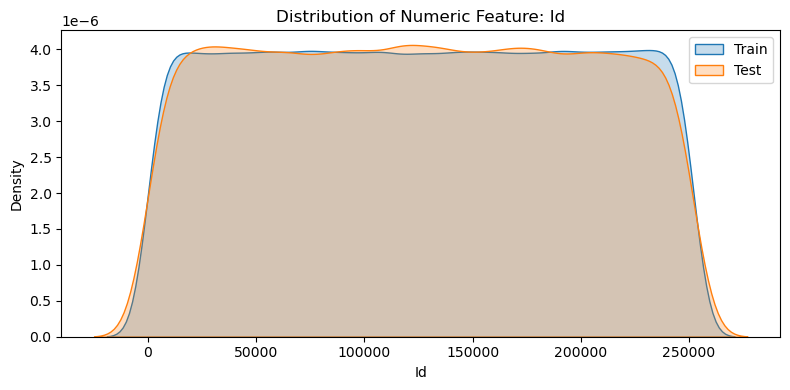

C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col].dropna(), label='Train', shade=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col].dropna(), label='Test', shade=True)


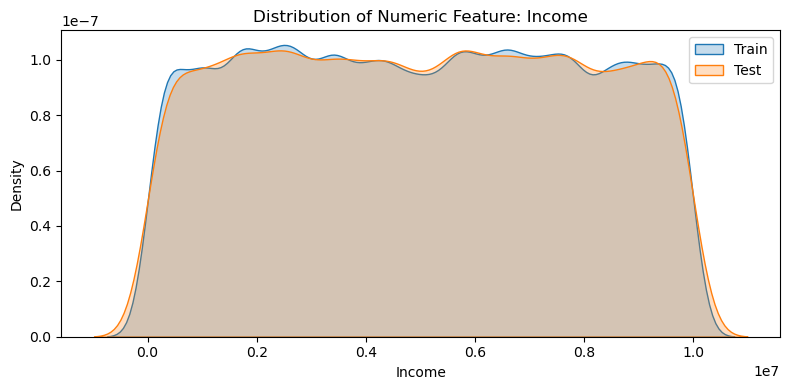

C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col].dropna(), label='Train', shade=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col].dropna(), label='Test', shade=True)


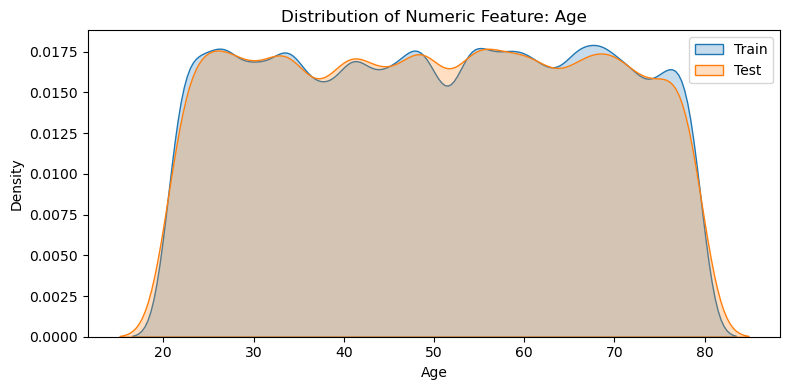

C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col].dropna(), label='Train', shade=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col].dropna(), label='Test', shade=True)


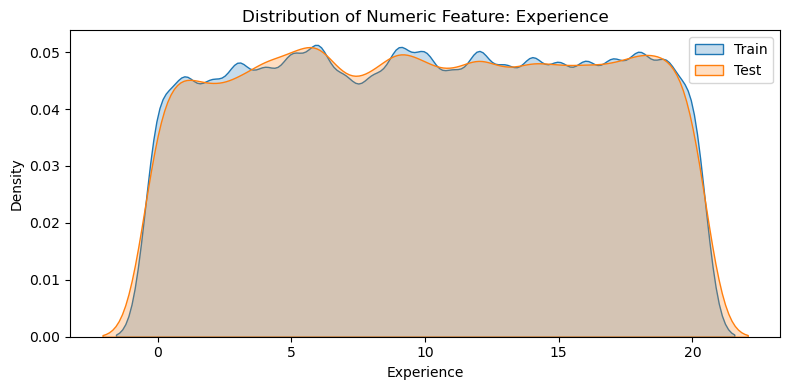

C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col].dropna(), label='Train', shade=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col].dropna(), label='Test', shade=True)


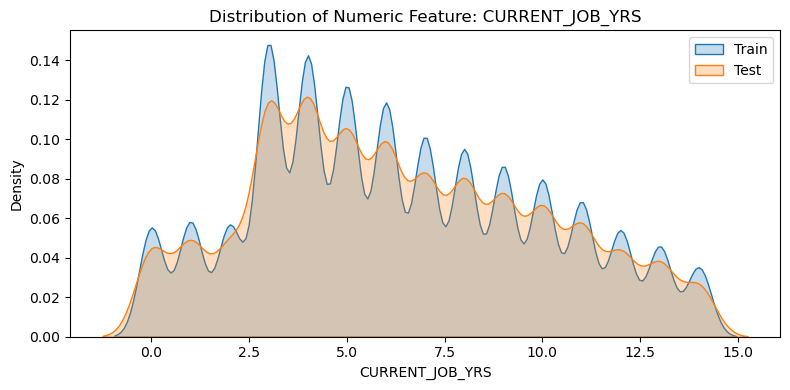

C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col].dropna(), label='Train', shade=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17972\2000694725.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col].dropna(), label='Test', shade=True)


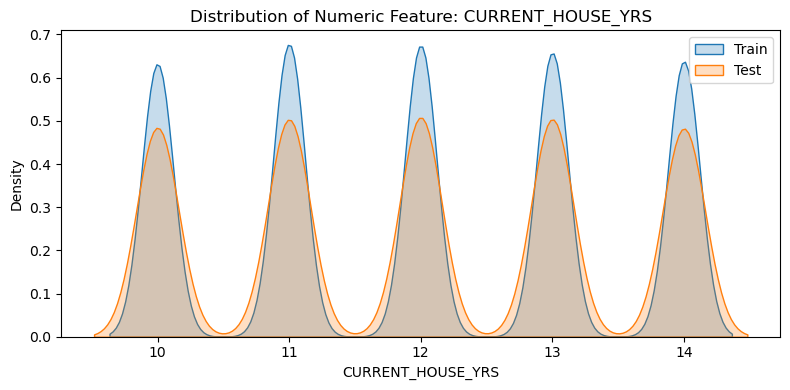

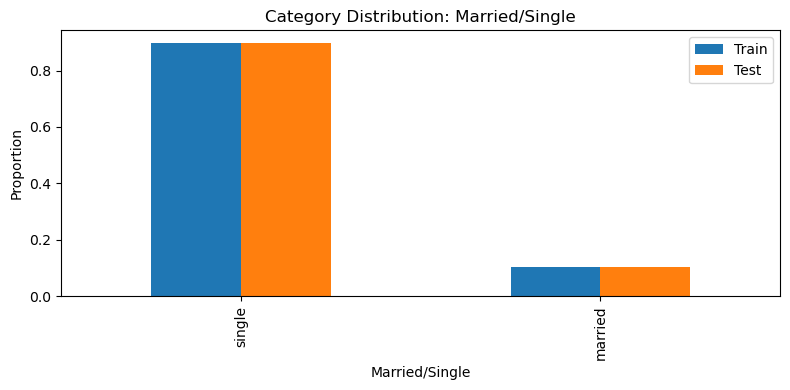

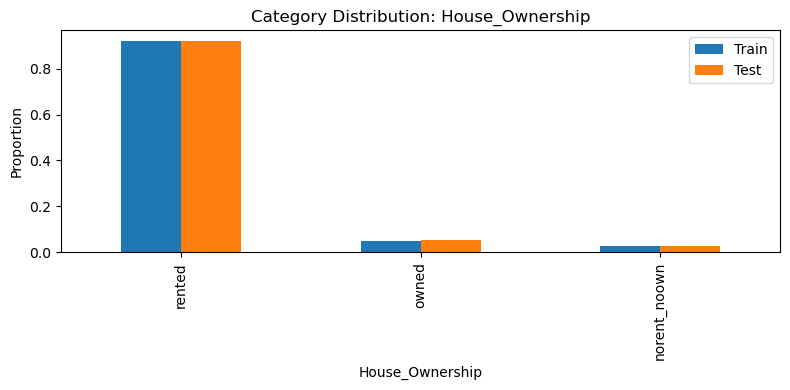

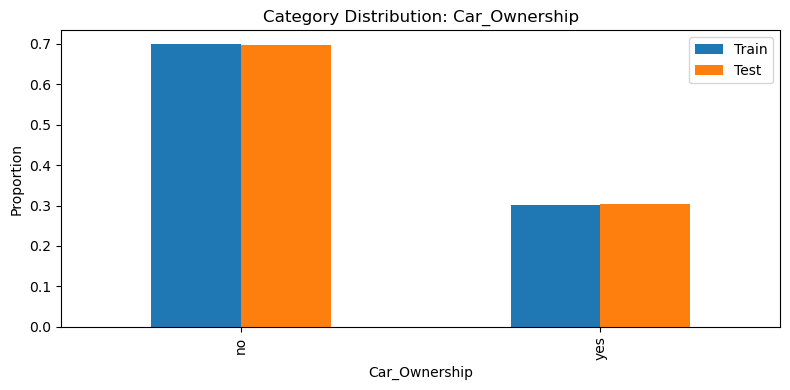

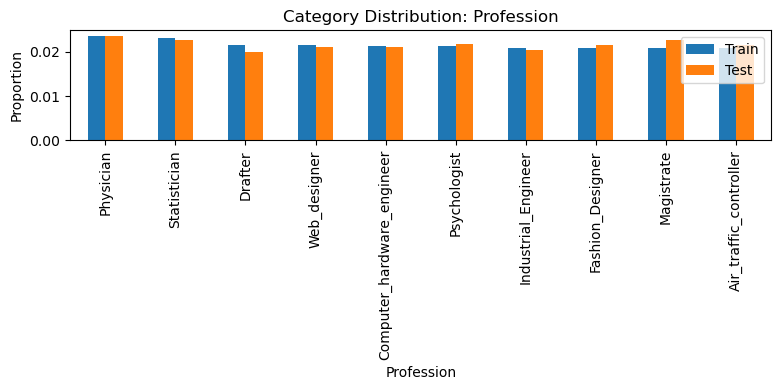

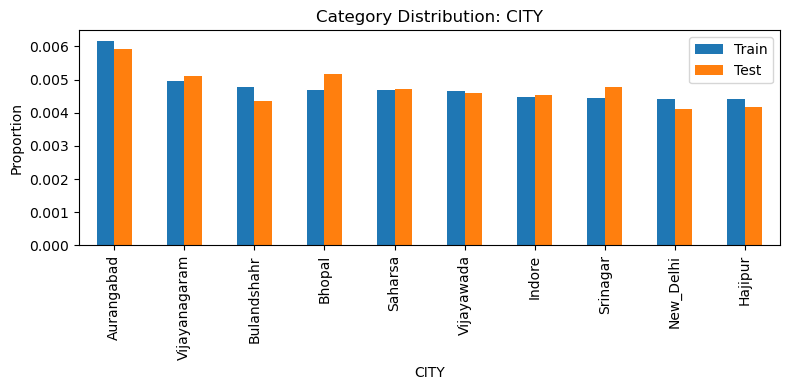

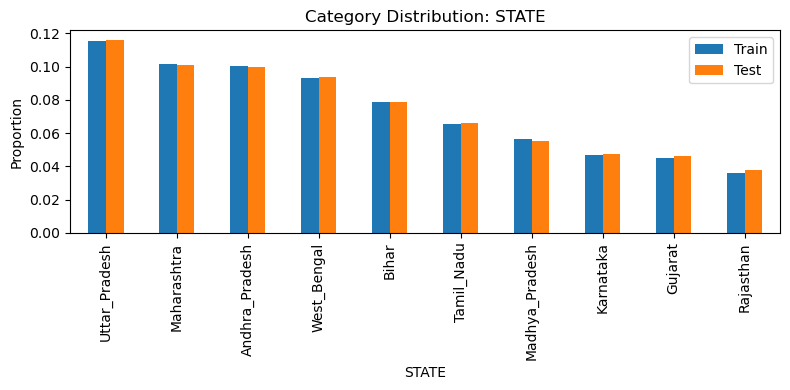

In [7]:
plot_feature_distributions(train, test)


## Key Insight:

Numeric Features:
- All numeric features have very similar means and standard deviations across train and test.
- No null values.
-No warning flags triggered

Conclusion: Numeric features are well distributed between train and test. 

Categorical Features:
- Top categories (like 'single' in Married/Single, 'rented' in House_Ownership) have identical proportions in both sets.
- Even CITY and STATE have consistent top categories and no nulls.
- No unseen categories from test in train.

Conclusion: Categorical features are also consistently distributed between sets.

With this, lets proceed to check the relationship that exist between our features using only our train dataset. this will help detect redundancy and reduce multicollinearity.


In [8]:
# A function that performs feature interaction analysis on our categorical train dataset

def cramers_v(confusion_matrix):
    """
    Computes CramÃ©râ€™s V statistic for categorical-categorical association.
    
    Args:
        confusion_matrix (pd.DataFrame): Contingency table (e.g., from pd.crosstab)

    Returns:
        float: CramÃ©r's V statistic
    """
    chi2, _, _, _ = chi2_contingency(confusion_matrix, correction=False)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))  # Bias correction
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    
def categorical_relationships_cramers_v(df, cat_features, plot=True):
    """
    Computes CramÃ©râ€™s V statistic between pairs of categorical features.

    Args:
        df (DataFrame): Input DataFrame.
        cat_features (list): List of categorical column names.
        plot (bool): Whether to plot the heatmap.

    Returns:
        pd.DataFrame: CramÃ©r's V matrix.
    """
    cramers_results = pd.DataFrame(index=cat_features, columns=cat_features)

    for col1 in cat_features:
        for col2 in cat_features:
            if col1 == col2:
                cramers_results.loc[col1, col2] = 1.0
            else:
                confusion_mat = pd.crosstab(df[col1], df[col2])
                v = cramers_v(confusion_mat)
                cramers_results.loc[col1, col2] = round(v, 3)

    cramers_results = cramers_results.astype(float)

    if plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cramers_results, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
        plt.title("CramÃ©r's V Heatmap (Categorical Feature Associations)")
        plt.tight_layout()
        plt.show()

    return cramers_results


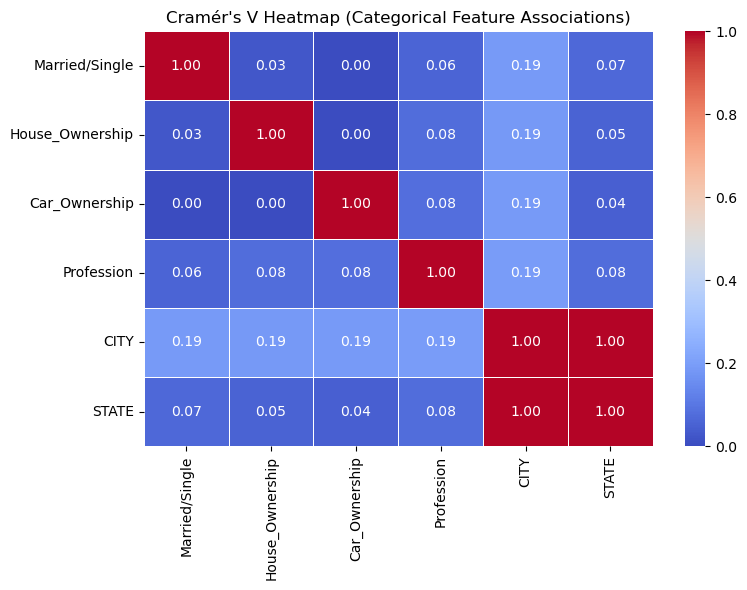

In [9]:
cat_features = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
cramers_matrix = categorical_relationships_cramers_v(train, cat_features)



In [10]:
# A function that performs interactive feature analysis on our numerical features  
def numerical_relationships_corr(df, num_features, plot_pairplot=False):
    """
    Computes correlation matrix and visualizes relationships between numerical features.

    Args:
        df (DataFrame): Input DataFrame.
        num_features (list): List of numerical column names.
        plot_pairplot (bool): If True, also displays a pairplot.

    Returns:
        pd.DataFrame: Correlation matrix.
    """
    # Compute correlation matrix
    corr_matrix = df[num_features].corr()

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap (Numerical Feature Associations)")
    plt.tight_layout()
    plt.show()

    # Optional: Pairplot
    if plot_pairplot:
        sns.pairplot(df[num_features], corner=True)
        plt.suptitle("Pairwise Relationships Between Numerical Features", y=1.02)
        plt.show()

    return corr_matrix


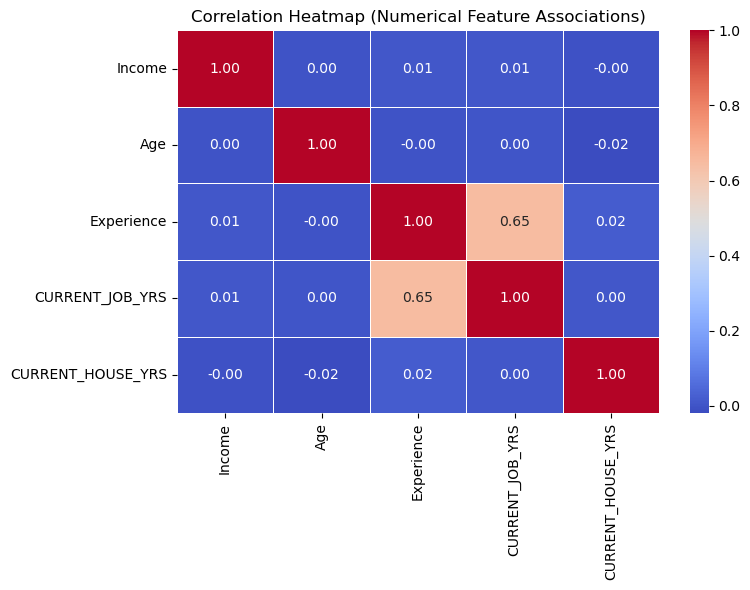

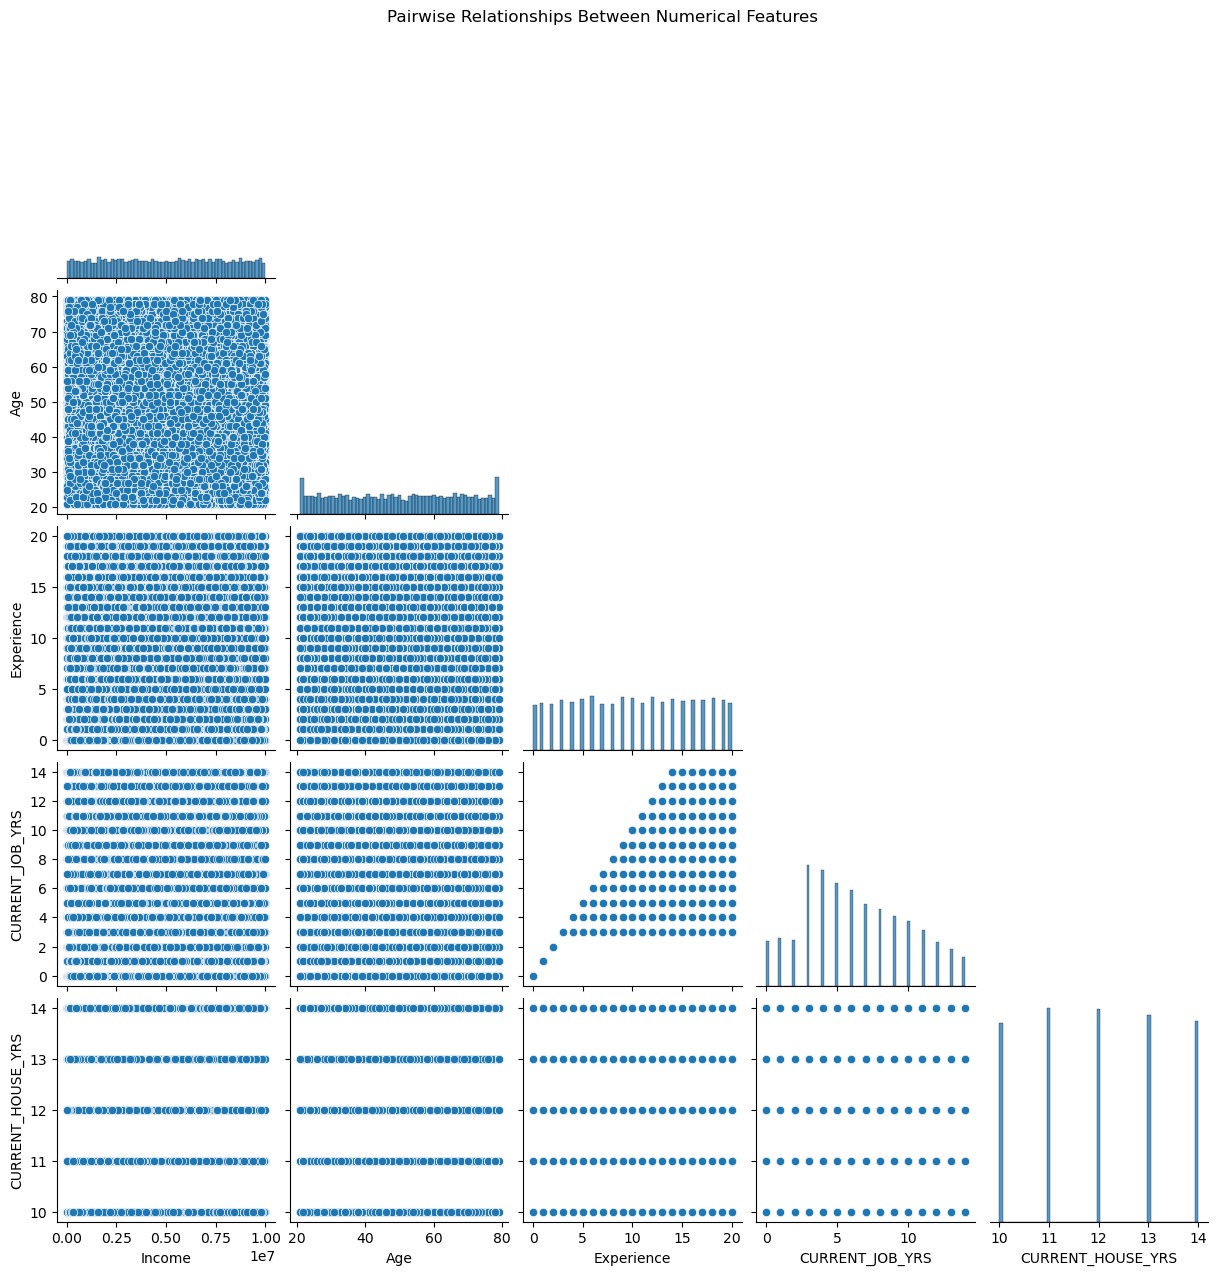

In [11]:
num_features = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
corr_matrix = numerical_relationships_corr(train, num_features, plot_pairplot=True)


##  Feature Interaction Analysis Report
### Overview
This report summarizes the exploratory analysis of feature interactions in the training dataset. The objective was to understand relationships between both numeric and categorical features before proceeding with modeling.

### ðŸ›  Tools Used
- Correlation Heatmap
- Pairwise Scatterplots (Pairplot)
- CramÃ©râ€™s V Correlation Matrix

### ðŸ”¢ Numeric Features

Key Findings:
- Most numeric feature pairs show weak or no linear relationship:
- Correlation coefficients are close to 0.
- Scatterplots reveal dispersed data points with no clear trends.

### Notable exception:

Experience vs CURRENT_JOB_YRS:
- Displays a moderate positive correlation.
- Scatterplot shows a loose upward trend.
- Suggests that individuals with more experience tend to have longer job tenure.

### ðŸ”¤ Categorical Features

Key Findings:
- Most categorical feature pairs exhibit low association (CramÃ©râ€™s V < 0.3).
- Indicates that categorical features are largely independent and non-redundant.
- No strong overlap or collinearity was observed among the categorical variables.

### âœ… Conclusion

- Low multicollinearity was observed among both numeric and categorical features.
- The pair Experience and CURRENT_JOB_YRS may be partially redundant and should be reviewed during feature selection.
- The general independence between features is beneficial for modeling, supporting better generalization and interpretability.